### Train a Simple Neural Network on Abalone Dataset

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
import os

input_path = '../data/abalone'
output_path = '../output'
output_path_nn = os.path.join(output_path, 'neural_net')
os.makedirs(output_path_nn, exist_ok=True)

In [2]:
# read back the files saved previously (uses existing output_path, pd, np, pickle, os)
df_train_x_scaled = pd.read_pickle(os.path.join(output_path, 'df_train_x_scaled.pkl'))
df_test_x_scaled  = pd.read_pickle(os.path.join(output_path, 'df_test_x_scaled.pkl'))

np_train_y_scaled = np.load(os.path.join(output_path, 'np_train_y_scaled.npy'))
np_test_y_scaled  = np.load(os.path.join(output_path, 'np_test_y_scaled.npy'))

with open(os.path.join(output_path, 'scaler_x.pkl'), 'rb') as f:
    scaler_x = pickle.load(f)
with open(os.path.join(output_path, 'scaler_y.pkl'), 'rb') as f:
    scaler_y = pickle.load(f)

# quick verification
print('df_train_x_scaled:', type(df_train_x_scaled), df_train_x_scaled.shape)
print('df_test_x_scaled :', type(df_test_x_scaled), df_test_x_scaled.shape)
print('np_train_y_scaled:', type(np_train_y_scaled), np_train_y_scaled.shape)
print('np_test_y_scaled :', type(np_test_y_scaled), np_test_y_scaled.shape)
print('scaler_x         :', type(scaler_x))
print('scaler_y         :', type(scaler_y))

df_train_x_scaled: <class 'pandas.core.frame.DataFrame'> (3341, 8)
df_test_x_scaled : <class 'pandas.core.frame.DataFrame'> (836, 8)
np_train_y_scaled: <class 'numpy.ndarray'> (3341, 1)
np_test_y_scaled : <class 'numpy.ndarray'> (836, 1)
scaler_x         : <class 'sklearn.preprocessing._data.StandardScaler'>
scaler_y         : <class 'sklearn.preprocessing._data.StandardScaler'>


In [3]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(df_train_x_scaled[['sex']])

X_train_sex_encoded = ohe.transform(df_train_x_scaled[['sex']])
X_test_sex_encoded = ohe.transform(df_test_x_scaled[['sex']])

train_encoded_df = pd.DataFrame(X_train_sex_encoded, columns=ohe.get_feature_names_out(['sex']), index=df_train_x_scaled.index)
test_encoded_df = pd.DataFrame(X_test_sex_encoded, columns=ohe.get_feature_names_out(['sex']), index=df_test_x_scaled.index)

# Join the encoded columns back to the original DataFrames
df_train = df_train_x_scaled.drop('sex', axis=1).join(train_encoded_df)
df_test = df_test_x_scaled.drop('sex', axis=1).join(test_encoded_df)

df_train.head()

,length,diam,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M
4038,0.210175,0.369725,-0.347950,-0.323164,-0.325407,-0.405130,-0.212132,0.0,1.0,0.0
1272,-0.419444,-0.542386,-0.936082,-0.665985,-0.480126,-0.820932,-0.712419,0.0,1.0,0.0
3384,-1.846581,-1.859881,-1.641840,-1.388250,-1.354628,-1.346395,-1.391379,1.0,0.0,0.0
3160,-2.098428,-2.113245,-1.759467,-1.453355,-1.363597,-1.533734,-1.462848,0.0,1.0,0.0
3894,-0.251546,-0.289022,-0.112697,-0.409632,-0.437522,-0.350299,-0.176398,0.0,0.0,1.0


Now that the data is loaded and ready with one-hot encoding. Let's build a Neural Network

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

x_train = df_train.values
y_train = np_train_y_scaled
x_test = df_test.values
y_test = np_test_y_scaled

batch_size = 32

train_dataset = TensorDataset(
    torch.tensor(x_train, dtype=torch.float32),
      torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(
    torch.tensor(x_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                               shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


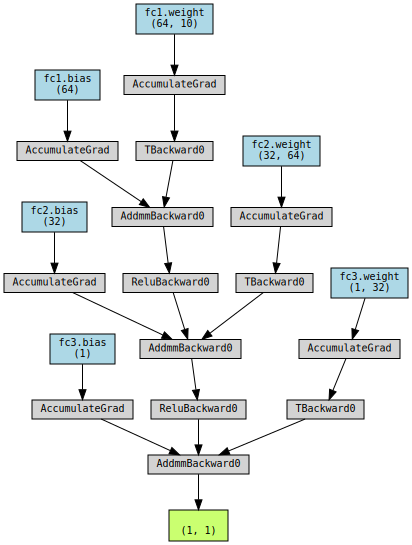

In [ ]:
import torchviz

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleNN(input_dim=x_train.shape[1])
model.to(torch.device(device))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dummy_tensor = torch.Tensor(1, x_train.shape[1]).to(device)
dot = torchviz.make_dot(model(dummy_tensor), params=dict(model.named_parameters()))
dot
# dot.render("simple_net_graph", format="png", cleanup=True)

Now, let's write the training code

In [38]:
num_epochs = 40

model = SimpleNN(input_dim=x_train.shape[1])
model.to(torch.device(device))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataloader.dataset)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/40], Loss: 0.4188
Epoch [20/40], Loss: 0.4026
Epoch [30/40], Loss: 0.3944
Epoch [40/40], Loss: 0.3885


In [39]:
# evaluate on test_dataloader

model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())
        test_loss += loss.item() * inputs.size(0)
    
    test_loss /= len(test_dataloader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.4261


Let's find error after inverse scaling the target & prediction

In [ ]:
# evaluate on test_dataloader

model.eval()

mae = nn.M

with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        outputs_unscaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 1)).squeeze()
        targets_unscaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 1)).squeeze()

        # Convert back to tensors for loss computation
        outputs_tensor = torch.tensor(outputs_unscaled, dtype=torch.float32)
        targets_tensor = torch.tensor(targets_unscaled, dtype=torch.float32)

        loss = criterion(outputs_tensor, targets_tensor)
        test_loss += loss.item() * inputs.size(0)
    
    test_loss /= len(test_dataloader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 4.3821


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
test_loss = 0.0
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Convert predictions and targets back to original scale
        outputs_unscaled = scaler_y.inverse_transform(outputs.cpu().numpy().reshape(-1, 1)).squeeze()
        targets_unscaled = scaler_y.inverse_transform(targets.cpu().numpy().reshape(-1, 1)).squeeze()

        all_preds.extend(outputs_unscaled)
        all_targets.extend(targets_unscaled)

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Compute metrics using sklearn
mse = mean_squared_error(all_targets, all_preds)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²:  {r2:.4f}")

# Optional: print a few predictions for quick comparison
print("Sample predictions:")
for i in range(5):
    print(f"Actual: {all_targets[i]:.2f} | Predicted: {all_preds[i]:.2f}")


Test MSE: 4.3821
Test MAE: 1.5073
Test R²:  0.5952
Sample predictions:
Actual: 10.50 | Predicted: 13.23
Actual: 9.50 | Predicted: 10.74
Actual: 17.50 | Predicted: 17.50
Actual: 10.50 | Predicted: 13.02
Actual: 15.50 | Predicted: 13.79


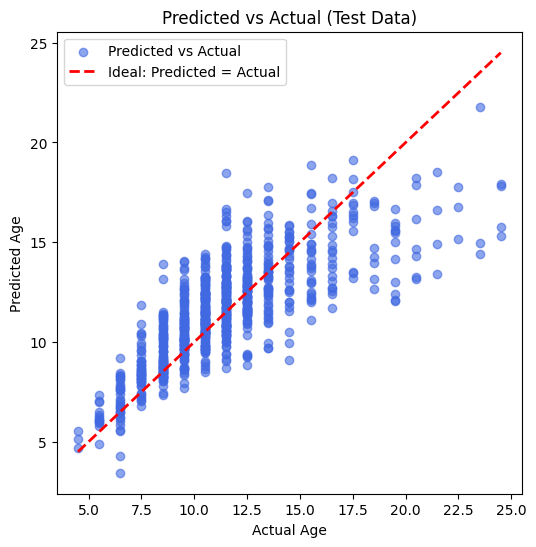

In [46]:
import matplotlib.pyplot as plt

os.makedirs(os.path.join(output_path, 'lin_reg_poly'), exist_ok=True)

plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds,
             alpha=0.6, color='royalblue', label='Predicted vs Actual')
plt.plot(
    [min(all_targets), max(all_targets)],
    [min(all_targets), max(all_targets)],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Ideal: Predicted = Actual'
)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs Actual (Test Data)')
plt.legend()

plt.savefig(output_path_nn+'/nn_plot.png', dpi=300, bbox_inches='tight')
plt.show()